# Basic Bayesian GMM with MCMC (via PyMC)

We assume the following basic generative model for our data:
\begin{align}
\pi &\sim Dir(\alpha_0)\\
\Sigma^{-1}_k &\sim Wish(\mathbf{W}_0, \nu_0)\\
\mu_k | \Sigma^{-1}_k &\sim \mathcal{N}(\mathbf{m}_0, (\beta_0 \Sigma^{-1}_k )^{-1})\\
z_n | \pi &\sim \prod_{k=1}^K \pi_k^{z_{n, k}}\\
x_n | Z, \mu, \Sigma^{-1} &\sim \prod_{k=1}^K \mathcal{N}(\mu_k, \Sigma^{-1}_k)^{z_{nk}}
\end{align}
Note that the parameters of our model is $\theta = (\alpha_0, \mathbf{W}_0, \nu_0, \mathbf{m}_0, \beta_0)$. 
<img src="graph_model.png" width="400px">
For convinience during some implementations, we will instead use a Normal-Inverse-Wishart prior for the mean and the covariance (rather that the mean and precision) of each component,
\begin{align}
\Sigma_k &\sim IW(\mathbf{S}_0, \nu_0)\\
\mu_k | \Sigma_k &\sim \mathcal{N}(\mathbf{m}_0, \mathbf{V}_0),
\end{align}
where $\mathbf{V}_0 = \frac{1}{k_0}\Sigma_k$.

In [10]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import seaborn as sns
sns.set_style("white")

import time
import timeit

import scipy.stats 
import pandas as pd
import pymc as pm
from sklearn import mixture

import re
import numpy as np

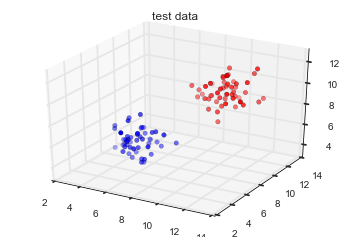

In [13]:
#-------------   data parameters
K = 2 #number of components
N = 100 #number of observations
M = 3 #number of attributes per observation

n_samples = int(N/2.0) #number of points in each component
mu1 = np.array([10, 10, 10]) #mean of component 1
mu2 = np.array([6, 6, 6]) #mean of component 1

# generate random sample, two components
np.random.seed(0)

# generate spherical data centered on mu1
comp1 = np.random.randn(n_samples, M) + mu1

# generate spherical data centered on mu2
comp2 = np.random.randn(N - n_samples, M) + mu2

# concatenate the two datasets into training set
data = np.vstack([comp1, comp2])

#plot the components
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(comp1[:, 0], comp1[:, 1], comp1[:, 2], c='r')
ax.scatter(comp2[:, 0], comp2[:, 1], comp2[:, 2], c='b')

plt.title('test data')
plt.show()

In [89]:
#Sampling parameters
iters =10000
burnin = 0.4

#-------------
#----------------------------- the model
#-------------

#-------------   model parameters
alpha = np.array( [0.5] * K ) #shape parameter 
nu = M + 1 #degrees of freedom (greater than M - 1)
W = np.eye(M) #scale matrix (positive)
beta = 1. #scale for wishart-normal dist
eta = np.array( [0] * M ) #mean for wishart-normal dist

#-------------   priors
#mixture coefficient
pi = pm.Dirichlet( 'pi', theta=alpha ) 
#precision matrices
L = dict()
for k in xrange(K):
    L[k] = pm.Wishart( 'L_{}'.format(k), n=nu, Tau=W )
    
#means
mu = dict()
for k in xrange(K):
    mu[k] = pm.MvNormal( 'mu_{}'.format(k), mu=eta, tau=beta * L[k] ) 
      
#latent component memembership
Z = pm.Categorical( 'Z', p=pi, size=N )

#list of means for data
@pm.deterministic
def mu_z(Z=Z, mu=mu):
    return [mu[Z[n]] for n in xrange(N)]

#list of precisions for data
@pm.deterministic
def L_z(Z=Z, L=L):
    return [L[Z[n]] for n in xrange(N)]

#-------------   likelihood
Y = dict()
for n in xrange(N):
    Y[n] = pm.MvNormal( 'Y_{}'.format(n), mu=mu_z[n], tau=L_z[n], 
                       value=data[n, :], observed=True ) 

#-------------
#----------------------------- Simple MCMC
#-------------

#-------------   sampling parameters
iters = 5000
burnin = 0.3

#-------------   pymc sampler
mc = pm.MCMC([pi, mu, L, Z, mu_z, L_z, Y])
mc.sample( iter=iters, burn=burnin * iters )
trace1 = mc.trace('mu_0')[:]
trace2 = mc.trace('mu_1')[:]
trace3 = mc.trace('L_0')[:]
trace4 = mc.trace('L_1')[:]

print '\n'
print 'posterior mean for mu1:', np.mean(trace1, axis=0)
print 'posterior mean for mu2:', np.mean(trace2, axis=0)

print '\n'
print 'posterior mean for L1:', np.linalg.inv(np.mean(trace3, axis=0))
print 'posterior mean for L2:', np.linalg.inv(np.mean(trace4, axis=0))

 [-----------------100%-----------------] 5000 of 5000 complete in 27.5 sec

posterior mean for mu1: [ 9.10642169  9.06534117]
posterior mean for mu2: [ 6.34900333  6.64960704]


posterior mean for L1: [[ 0.36168472  0.21606068]
 [ 0.21606068  1.67403464]]
posterior mean for L2: [[ 0.34773358 -0.23813438]
 [-0.23813438  1.19410082]]
